In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from datetime import date, timedelta, datetime 
from pandas.plotting import register_matplotlib_converters 
import matplotlib.dates as mdates 
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
sns.set_style('white', { 'axes.spines.right': False, 'axes.spines.top': False})

In [ ]:
from google.colab import auth
auth.authenticate_user()
import gspread
from google.auth import default
creds, _ = default()
gc = gspread.authorize(creds)
worksheet = gc.open('54 Column 2015-2018 Data (without column names)').sheet1
rows = worksheet.get_all_values()

In [ ]:
df = pd.DataFrame.from_records(rows)
df.columns  = ['Date',
               'Close',
               'Fees_Mean',
               'Fees_Median',
               'Fee_Ratio_Multiple',
               'UTXOs_in_Loss',
               'UTXO_Value_Created_Mean',
               'Blocks_Mined',
               'Block_Size_Mean',
               'Block_Interval_Median',
               'Block_Interval_Mean',
               'Velocity',
               'Stock-to-Flow_Deflection',
               'Seller_Exhaustion_Constant',
               'RHODL_Ratio',
               'Reserve_Risk',
               'Relative_Unrealized_Profit',
               'Relative_Unrealized_Loss',
               'Realized_Profit',
               'Realized_P_L_Ratio',
               'Realized_Loss',
               'Puell_Multiple',
               'Pi_Cycle_Top_Indicator_o.ma111',
               'Pi_Cycle_Top_Indicator_o.ma350x2',
               'NVT_Signal',
               'NVT_Ratio',
               'ASOL',
               'aSOPR',
               'Balanced_Price',
               'Coin_Days_Destroyed',
               'Investor_Capitalization',
               'MSOL',
               'Net_Realized_Profit_Loss',
               'Transaction_Count',
               'Transfer_Volume_Sum',
               'Transaction_Total_Size',
               'Accumulation_Trend_Score_Price',
               'Accumulation_Trend_Score',
               'Binary_CDD',
               'Difficulty_Ribbon_ma128',
               'Difficulty_Ribbon_ma14',
               'Difficulty_Ribbon_ma200',
               'Difficulty_Ribbon_ma25',
               'Difficulty_Ribbon_ma40',
               'Difficulty_Ribbon_ma60',
               'Difficulty_Ribbon_ma9',
               'Difficulty_Ribbon_ma90',
               'SOPR',
               'Supply-Adjusted_CDD',
               'Transaction_Rate',
               'Open',
               'High',
               'Low',
               'Adj_Close',
               'Volume']

df.set_index("Date", inplace=True)

for col in df.columns:
    df[col] = df[col].astype('float32')

In [ ]:
cor = df.corr()

In [ ]:
cor[(cor['Close'] >= 0.5) | (cor['Close'] <= -0.5)]

,Close,Fees_Mean,Fees_Median,Fee_Ratio_Multiple,UTXOs_in_Loss,UTXO_Value_Created_Mean,Blocks_Mined,Block_Size_Mean,Block_Interval_Median,Block_Interval_Mean,...,Difficulty_Ribbon_ma9,Difficulty_Ribbon_ma90,SOPR,Supply-Adjusted_CDD,Transaction_Rate,Open,High,Low,Adj_Close,Volume
Close,1.000000,0.389218,0.343293,-0.353626,0.091441,-0.213379,0.113050,0.499253,-0.112728,-0.114726,...,0.577272,0.536539,0.019373,0.083373,0.139040,0.997301,0.999013,0.998534,1.000000,0.928688
Stock-to-Flow_Deflection,0.752901,0.262969,0.228173,-0.113666,-0.077811,-0.078529,0.138349,0.195916,-0.138564,-0.140676,...,0.189276,0.145853,-0.048971,0.031860,0.074862,0.749416,0.756063,0.743530,0.752901,0.744125
Seller_Exhaustion_Constant,0.540338,0.629898,0.617990,-0.441408,-0.330377,-0.038313,0.126686,0.470911,-0.094075,-0.101999,...,0.054721,0.047920,-0.209749,0.178725,0.211295,0.538224,0.546849,0.527698,0.540338,0.530848
RHODL_Ratio,0.829852,0.670139,0.643162,-0.395324,-0.226937,-0.100925,0.178081,0.437970,-0.144749,-0.163594,...,0.106184,0.076245,-0.170126,0.147785,0.181715,0.829736,0.838618,0.816203,0.829852,0.821209
Reserve_Risk,0.889201,0.627968,0.596976,-0.435279,-0.224613,-0.125483,0.182699,0.490944,-0.151831,-0.169955,...,0.195604,0.160222,-0.169412,0.147255,0.180197,0.886477,0.894475,0.878905,0.889201,0.832476
Relative_Unrealized_Profit,0.548794,0.743976,0.731428,-0.733771,-0.629479,-0.065626,0.176273,0.678920,-0.167521,-0.175889,...,0.027708,-0.004356,-0.430833,0.204286,0.300439,0.542917,0.549848,0.541108,0.548794,0.438004
Realized_Profit,0.656723,0.530531,0.527835,-0.298629,-0.214729,-0.056472,0.129764,0.358434,-0.101378,-0.111106,...,0.065596,0.054661,-0.188670,0.070286,0.158295,0.644689,0.663411,0.634022,0.656723,0.676562
Realized_Loss,0.572163,0.304898,0.260523,-0.213531,0.247930,-0.119833,0.023740,0.351658,-0.029444,-0.014704,...,0.387861,0.384419,0.191168,0.107217,0.063099,0.592729,0.588529,0.562327,0.572163,0.703546
Puell_Multiple,0.535443,0.708109,0.702785,-0.510831,-0.534153,0.042558,0.377081,0.451084,-0.290404,-0.354043,...,-0.135577,-0.156146,-0.398996,0.202760,0.219363,0.529288,0.540801,0.521036,0.535443,0.468747
Pi_Cycle_Top_Indicator_o.ma111,0.890177,0.105444,0.045186,-0.261987,0.315491,-0.238609,0.044031,0.420709,-0.065324,-0.055513,...,0.732922,0.693695,0.182329,0.024312,0.049527,0.893096,0.887396,0.898019,0.890177,0.819575


In [ ]:
temp = cor[(cor['Close'] >= 0.5) | (cor['Close'] <= -0.5)].index
temp

Index(['Close', 'Stock-to-Flow_Deflection', 'Seller_Exhaustion_Constant',
       'RHODL_Ratio', 'Reserve_Risk', 'Relative_Unrealized_Profit',
       'Realized_Profit', 'Realized_Loss', 'Puell_Multiple',
       'Pi_Cycle_Top_Indicator_o.ma111', 'Pi_Cycle_Top_Indicator_o.ma350x2',
       'Balanced_Price', 'Investor_Capitalization', 'Transaction_Total_Size',
       'Difficulty_Ribbon_ma128', 'Difficulty_Ribbon_ma14',
       'Difficulty_Ribbon_ma25', 'Difficulty_Ribbon_ma40',
       'Difficulty_Ribbon_ma60', 'Difficulty_Ribbon_ma9',
       'Difficulty_Ribbon_ma90', 'Open', 'High', 'Low', 'Adj_Close', 'Volume'],
      dtype='object')

In [ ]:
temp.shape

(26,)

In [ ]:
# Comment below if you don't select data with correlation
df = df[temp]

In [ ]:
df

,Close,Stock-to-Flow_Deflection,Seller_Exhaustion_Constant,RHODL_Ratio,Reserve_Risk,Relative_Unrealized_Profit,Realized_Profit,Realized_Loss,Puell_Multiple,Pi_Cycle_Top_Indicator_o.ma111,...,Difficulty_Ribbon_ma25,Difficulty_Ribbon_ma40,Difficulty_Ribbon_ma60,Difficulty_Ribbon_ma9,Difficulty_Ribbon_ma90,Open,High,Low,Adj_Close,Volume
Date,,,,,,,,,,,,,,,,,,,,,
1/1/2015,314.250000,1.421979,0.031734,247.951889,0.001781,0.364847,2.861970e+05,8.423956e+05,0.61,367.890015,...,1.710000e+25,1.720000e+24,1.710000e+25,1.710000e+25,1.640000e+25,320.440002,320.440002,314.000000,314.250000,8.036550e+06
1/2/2015,315.029999,1.430472,0.031199,244.652252,0.001773,0.365072,3.935750e+05,1.642649e+06,0.61,366.450012,...,1.710000e+25,1.720000e+25,1.710000e+24,1.720000e+25,1.650000e+25,314.079987,315.839996,313.570007,315.029999,7.860650e+06
1/3/2015,281.079987,1.306703,0.029003,266.790405,0.001707,0.357438,3.773302e+05,8.734940e+06,0.58,364.890015,...,1.710000e+25,1.720000e+25,1.710000e+25,1.720000e+25,1.650000e+25,314.850006,315.149994,281.079987,281.079987,3.305440e+07
1/4/2015,264.200012,1.194931,0.034340,275.789673,0.001547,0.353442,1.551772e+06,1.023080e+07,0.56,363.089996,...,1.710000e+25,1.720000e+24,1.720000e+25,1.730000e+25,1.650000e+25,281.149994,287.230011,257.609985,264.200012,5.562910e+07
1/5/2015,274.470001,1.249843,0.035999,279.157318,0.001541,0.356353,8.702446e+05,1.033541e+07,0.51,361.339996,...,1.710000e+25,1.720000e+25,1.720000e+25,1.730000e+25,1.660000e+25,265.079987,278.339996,265.079987,274.470001,4.396280e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12/27/2018,3654.830078,0.517925,0.035441,344.260925,0.001697,0.335774,2.532248e+07,9.740213e+07,0.57,5531.109863,...,2.330000e+27,2.530000e+26,2.710000e+27,2.190000e+27,2.850000e+27,3854.689941,3874.419922,3645.449951,3654.830078,5.130000e+09
12/28/2018,3923.919922,0.558852,0.040129,332.321533,0.001685,0.344615,2.804604e+07,1.771026e+08,0.54,5507.069824,...,2.320000e+27,2.510000e+27,2.690000e+27,2.190000e+27,2.840000e+27,3653.129883,3956.139893,3642.629883,3923.919922,5.630000e+09
12/29/2018,3820.409912,0.562239,0.034473,369.514160,0.001760,0.340493,2.684074e+07,1.662663e+08,0.47,5485.399902,...,2.310000e+27,2.500000e+27,2.680000e+26,2.190000e+27,2.830000e+27,3932.489990,3963.760010,3820.409912,3820.409912,4.990000e+09


**Preparing Train Data Set** 

In [ ]:
train_df = df.copy()

data_filtered = pd.DataFrame(train_df)

#Only Prices
#features = ["Open", "High", "Low", "Close"]
#data_filtered = data_filtered[features].copy()

data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['Close']

data_filtered_ext.tail()

,Close,Stock-to-Flow_Deflection,Seller_Exhaustion_Constant,RHODL_Ratio,Reserve_Risk,Relative_Unrealized_Profit,Realized_Profit,Realized_Loss,Puell_Multiple,Pi_Cycle_Top_Indicator_o.ma111,...,Difficulty_Ribbon_ma40,Difficulty_Ribbon_ma60,Difficulty_Ribbon_ma9,Difficulty_Ribbon_ma90,Open,High,Low,Adj_Close,Volume,Prediction
Date,,,,,,,,,,,,,,,,,,,,,
12/27/2018,3654.830078,0.517925,0.035441,344.260925,0.001697,0.335774,25322480.0,97402128.0,0.57,5531.109863,...,2.530000e+26,2.710000e+27,2.190000e+27,2.850000e+27,3854.689941,3874.419922,3645.449951,3654.830078,5.130000e+09,3654.830078
12/28/2018,3923.919922,0.558852,0.040129,332.321533,0.001685,0.344615,28046036.0,177102640.0,0.54,5507.069824,...,2.510000e+27,2.690000e+27,2.190000e+27,2.840000e+27,3653.129883,3956.139893,3642.629883,3923.919922,5.630000e+09,3923.919922
12/29/2018,3820.409912,0.562239,0.034473,369.514160,0.001760,0.340493,26840736.0,166266304.0,0.47,5485.399902,...,2.500000e+27,2.680000e+26,2.190000e+27,2.830000e+27,3932.489990,3963.760010,3820.409912,3820.409912,4.990000e+09,3820.409912
12/30/2018,3865.949951,0.549443,0.034849,338.143890,0.001726,0.341863,9809938.0,70455120.0,0.59,5463.109863,...,2.480000e+27,2.660000e+27,2.190000e+27,2.820000e+27,3822.389893,3901.909912,3797.219971,3865.949951,4.770000e+09,3865.949951
12/31/2018,3742.699951,0.531073,0.031358,323.371460,0.001701,0.337775,6979245.0,103199264.0,0.52,5440.330078,...,2.470000e+27,2.650000e+27,2.220000e+27,2.810000e+27,3866.840088,3868.739990,3725.870117,3742.699951,4.660000e+09,3742.699951


In [ ]:
nrows = data_filtered.shape[0]

np_data_unscaled = np.array(data_filtered)
np_data = np.reshape(np_data_unscaled, (nrows, -1))
print(np_data.shape)

scaler = MinMaxScaler()
np_data_scaled = scaler.fit_transform(np_data_unscaled)
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext['Close'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)

(1461, 26)


In [ ]:
sequence_length = 45

index_Close = data_filtered_ext.columns.get_loc("Close")

train_data_len = math.ceil(np_data_scaled.shape[0] * 0.8)

train_data = np_data_scaled[0:train_data_len, :]
test_data = np_data_scaled[train_data_len - sequence_length:, :]

def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) 
        y.append(data[i, index_Close])
    
    x = np.array(x)
    y = np.array(y)
    return x, y


x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(1124, 45, 26) (1124,)
(292, 45, 26) (292,)
0.0029364415
0.0029364415


In [ ]:
model = Sequential()
model.add(LSTM(units=64, return_sequences=False, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(0.2))
#model.add(LSTM(units=32, return_sequences=False))
#model.add(Dropout(0.2))
model.add(Dense(1))
adam = Adam(learning_rate=0.0008)
model.compile(optimizer=adam, loss='mean_squared_error')
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 64)                23296     
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 23,361
Trainable params: 23,361
Non-trainable params: 0
_________________________________________________________________


**Scaling Train Data Set**

In [ ]:
# Training the model
epochs = 200
batch_size = 32
early_stop = EarlyStopping(monitor='val_loss', mode="min", patience=50, verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    callbacks=[early_stop],
                    validation_split=0.2,
                    shuffle=False,
                   )

Epoch 1/200
29/29 [==============================] - 3s 43ms/step - loss: 0.0013 - val_loss: 0.0216
Epoch 2/200
29/29 [==============================] - 1s 26ms/step - loss: 0.0013 - val_loss: 0.0635
Epoch 3/200
29/29 [==============================] - 1s 27ms/step - loss: 0.0011 - val_loss: 0.0322
Epoch 4/200
29/29 [==============================] - 1s 26ms/step - loss: 0.0013 - val_loss: 0.0258
Epoch 5/200
29/29 [==============================] - 1s 26ms/step - loss: 2.7794e-04 - val_loss: 0.0124
Epoch 6/200
29/29 [==============================] - 1s 26ms/step - loss: 4.1001e-04 - val_loss: 0.0161
Epoch 7/200
29/29 [==============================] - 1s 25ms/step - loss: 2.8843e-04 - val_loss: 0.0169
Epoch 8/200
29/29 [==============================] - 1s 27ms/step - loss: 3.0900e-04 - val_loss: 0.0179
Epoch 9/200
29/29 [==============================] - 1s 26ms/step - loss: 1.3283e-04 - val_loss: 0.0231
Epoch 10/200
29/29 [==============================] - 1s 26ms/step - loss: 1.242

In [ ]:
# Get the predicted values
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# R2
r2 = r2_score(y_test_unscaled, y_pred)
print(f'R2: {np.round(r2, 2)}')

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

10/10 [==============================] - 0s 8ms/step
R2: 0.67
Median Absolute Error (MAE): 624.0
Mean Absolute Percentage Error (MAPE): 12.05 %


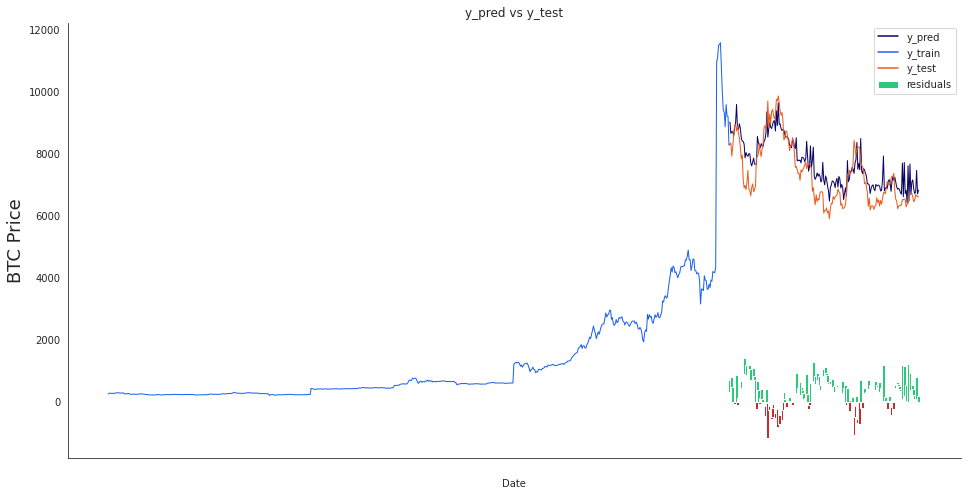

In [ ]:
# The date from which on the date is displayed
display_start_date = "2015-01-01" 

# Add the difference between the valid and predicted prices
train = pd.DataFrame(data_filtered_ext['Close'][:train_data_len + 1]).rename(columns={'Close': 'y_train'})
valid = pd.DataFrame(data_filtered_ext['Close'][train_data_len:]).rename(columns={'Close': 'y_test'})
valid.insert(1, "y_pred", y_pred, True)
valid.insert(1, "residuals", valid["y_pred"] - valid["y_test"], True)
df_union = pd.concat([train, valid])

# Zoom in to a closer timeframe
df_union_zoom = df_union[df_union.index > display_start_date]

# Create the lineplot
fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("y_pred vs y_test")
plt.ylabel("BTC Price", fontsize=18)
sns.set_palette(["#090364", "#1960EF", "#EF5919"])

sns.lineplot(data=df_union_zoom[['y_pred', 'y_train', 'y_test']], linewidth=1.0, dashes=False, ax=ax1)


# Create the bar plot with the differences
df_sub = ["#2BC97A" if x > 0 else "#C92B2B" for x in df_union_zoom["residuals"].dropna()]
ax1.bar(height=df_union_zoom['residuals'].dropna(), x=df_union_zoom['residuals'].dropna().index, width=3, label='residuals', color=df_sub)

#dates = list(data_filtered_ext.index)
#ax1.set_xticks(dates[::60])
#ax1.set_xticklabels(dates[::60], rotation=90)

#ax1.set_xlim(2015,2018)
#ax1.set_xticks([2015, 2016, 2017, 2018, 2019, 2020, 2021])
ax1.set(xticklabels=[' ', ' '])
#ax1.tick_params(axis='x', rotation=30)
#ax1.tick_params(bottom=False)  #
plt.legend()
plt.show()